# 분석 목표: 압연공정에서 후판 Scale 불량 발생 근본 원인 분석과 개선 기회 도출

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats
from scipy import stats
from scipy.stats import ttest_rel
from scipy.stats import ttest_ind
from scipy.stats import shapiro
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.stattools import omni_normtest

from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.api import qqplot, add_constant

from sklearn.preprocessing import scale, minmax_scale, robust_scale
from sklearn.preprocessing import StandardScaler


%matplotlib inline

# sns.set(font="AppleGothic")
plt.rc('font',  family='AppleGothic')
plt.rcParams['axes.unicode_minus']=False

# %matplotlib inline
# sns.set(font="AppleGothic")
# plt.rcParams['axes.unicode_minus']=False

# 0.데이터 조사: 후판 제조 공정 이해

### 후판이란?
후판 제품은 두께 4.5mm 이상의 비교적 두꺼운 열간 압연 강판

### 제조 공정 
연속 주조기에서 생산된 슬래브(Slab)를 고객사가 요구하는 치수로 압연 및 냉각한 후 최종 제품 크기로 절단하여 생산

### 가열로>HSB>압연(조압연, 사상압연)>가속냉각(TMCP)>열간교정>절단>열처리>검사(초음파)

가열로는 장입대, 예열대, 가열대 및 균열대 순서로 구성
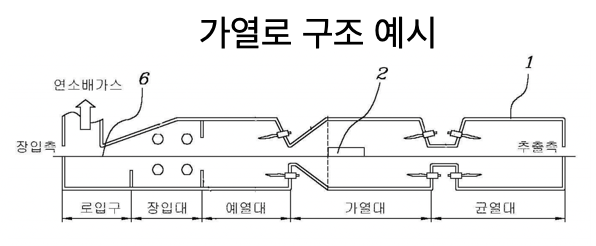

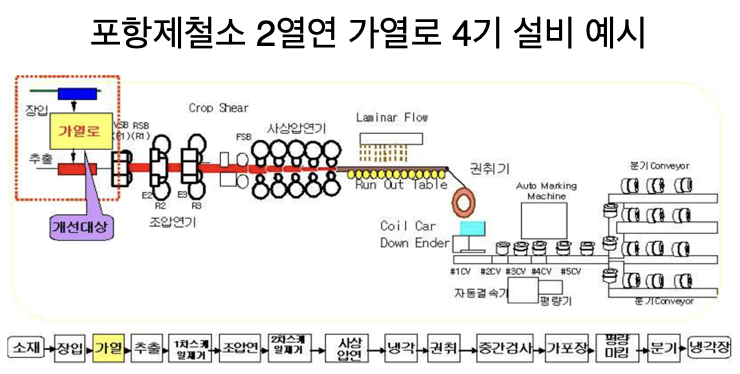

# 1. 가설 설정:  영향을 주는 원인 인자에 대한 가설 설정


# 1. 데이터 수집

In [2]:
df = pd.read_csv('SCALE불량.csv', engine='python', encoding='cp949')
df.head(n=3)

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,PB562774,2008-08-01:00:00:15,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,116,1133,59,282,1125,934,적용,8,2조
1,PB562775,2008-08-01:00:00:16,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,122,1135,53,283,1120,937,적용,8,2조
2,PB562776,2008-08-01:00:00:59,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1129,116,1121,55,282,1106,889,적용,8,3조


# 2. 데이터 정제
## 데이터 현황(데이터 속성, 기술통계, 분포, 이상치/결측치)확인 및 처리, 데이터 변환, 


# 2-1. 데이터 속성: 범주형 변수와 연속형 변수 확인
총 720개 데이터이며 결측치가 없다.

목표변수는 범주형 변수이고, 설명 변수에도 범주형 변수가 존재한다.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PLATE_NO           720 non-null    object 
 1   ROLLING_DATE       720 non-null    object 
 2   SCALE              720 non-null    object 
 3   SPEC               720 non-null    object 
 4   STEEL_KIND         720 non-null    object 
 5   PT_THK             720 non-null    float64
 6   PT_WDTH            720 non-null    int64  
 7   PT_LTH             720 non-null    int64  
 8   PT_WGT             720 non-null    int64  
 9   FUR_NO             720 non-null    object 
 10  FUR_NO_ROW         720 non-null    int64  
 11  FUR_HZ_TEMP        720 non-null    int64  
 12  FUR_HZ_TIME        720 non-null    int64  
 13  FUR_SZ_TEMP        720 non-null    int64  
 14  FUR_SZ_TIME        720 non-null    int64  
 15  FUR_TIME           720 non-null    int64  
 16  FUR_EXTEMP         720 non

# 2-2. 데이터 속성: 기술통계량 확인


In [4]:
# object 데이터와 숫자형 데이터 
# 로지스틱 회귀, SVM, NN, K-NN 모델을 위한 scale 변환 필요성 확인
df_num=df.select_dtypes(exclude='object')
df_char=df.select_dtypes(include='object')

In [5]:
df_num.describe()

,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,29.267857,2807.127778,34323.269444,41481.777778,1.497222,1155.338889,88.204167,1149.666667,75.330556,300.563889,1139.570833,933.920833,8.319444
std,19.152651,517.839690,13828.434837,24751.322015,0.500340,20.866398,36.248696,17.571788,26.086390,45.390303,17.857121,107.863887,1.623252
min,12.030000,1800.000000,7893.000000,7820.000000,1.000000,1103.000000,43.000000,1113.000000,35.000000,221.000000,1102.000000,0.000000,5.000000
25%,16.090000,2466.000000,22663.000000,17757.500000,1.000000,1139.000000,65.000000,1132.000000,57.750000,257.000000,1122.750000,889.750000,6.000000
50%,20.130000,2725.000000,37380.000000,36120.000000,1.000000,1158.000000,75.000000,1155.000000,67.500000,304.000000,1144.000000,951.000000,8.000000
75%,40.000000,3125.000000,43735.000000,61120.000000,2.000000,1171.000000,101.000000,1164.000000,85.250000,342.000000,1154.000000,994.250000,10.000000
max,100.340000,4575.000000,54917.000000,115080.000000,2.000000,1206.000000,251.000000,1185.000000,194.000000,398.000000,1175.000000,1078.000000,10.000000


In [6]:
df_char

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,FUR_NO,HSB,WORK_GR
0,PB562774,2008-08-01:00:00:15,양품,AB/EH32-TM,T1,1호기,적용,2조
1,PB562775,2008-08-01:00:00:16,양품,AB/EH32-TM,T1,1호기,적용,2조
2,PB562776,2008-08-01:00:00:59,양품,NV-E36-TM,T8,2호기,적용,3조
3,PB562777,2008-08-01:00:01:24,양품,NV-E36-TM,T8,2호기,적용,3조
4,PB562778,2008-08-01:00:01:44,양품,BV-EH36-TM,T8,3호기,적용,1조
...,...,...,...,...,...,...,...,...
715,PB563502,2008-08-02:13:35:36,불량,NK-KA,C0,3호기,적용,2조
716,PB563503,2008-08-02:13:35:02,양품,NV-A32,C0,2호기,적용,1조
717,PB563504,2008-08-02:14:40:00,양품,NV-A32,C0,2호기,적용,4조
718,PB563505,2008-08-02:13:35:19,양품,LR-A,C0,3호기,적용,2조


In [7]:
# SPEC
pd.crosstab(df['SCALE'],df['SPEC'])

SPEC,A131-DH36TM,A283-C,A516-60,A709-36,AB/A,AB/AH32,AB/B,AB/EH32-TM,AB/EH36-TM,API-2W-50T,...,NV-A32-TM,NV-A36-TM,NV-B,NV-D32-TM,NV-D36-TM,NV-E32-TM,NV-E36-TM,PILAC-BT33,SA283-C,V42JBN3
SCALE,,,,,,,,,,,,,,,,,,,,,
불량,1,5,1,0,4,1,3,0,1,0,...,1,0,2,0,1,0,0,2,10,1
양품,0,1,1,1,3,4,3,2,16,2,...,2,2,1,4,4,2,5,38,11,3


In [8]:
for _ in pd.crosstab(df['SCALE'],df['SPEC']).columns:
    print(_)

A131-DH36TM
A283-C
A516-60
A709-36
AB/A
AB/AH32
AB/B
AB/EH32-TM
AB/EH36-TM
API-2W-50T
BV-A
BV-AH32
BV-AH32-TM
BV-AH36-TL
BV-AH36-TM
BV-B
BV-EH32-TM
BV-EH36-TM
CCS-B
COMMON
GL-A
GL-A32
GL-A32-TM
GL-A36-TM
GL-D36-TM
GL-E32-TM
GL-E36-TM
JS-SM400A
JS-SM400B
JS-SM490A
JS-SM490YA
JS-SM490YB
JS-SS400
KR-A
KR-AH32
KR-B
KS-HSB500
KS-HSB600
KS-SM400A
KS-SM400B
KS-SM490A
KS-SM490B
KS-SS400
LR-A
LR-AH32
LR-AH36
LR-AH36-TM
LR-B
LR-EH32-TM
LR-EH36-TM
NK-KA
NK-KA32
NK-KA32-TM
NK-KD36-TM
NV-A
NV-A32
NV-A32-TM
NV-A36-TM
NV-B
NV-D32-TM
NV-D36-TM
NV-E32-TM
NV-E36-TM
PILAC-BT33
SA283-C
V42JBN3


In [9]:
# 우세한 강종은 C0이다.
# C1은 불량률 100%이다.
# T3는 불량률 0%이다.
# 파생변수 생성: 강종에는 C, T type이 있다.
pd.crosstab(df['SCALE'],df['STEEL_KIND'], margins=True)

STEEL_KIND,C0,C1,C3,T0,T1,T3,T5,T7,T8,All
SCALE,,,,,,,,,,
불량,212,1,1,2,2,0,2,6,5,231
양품,291,0,6,14,16,2,41,29,90,489
All,503,1,7,16,18,2,43,35,95,720


In [10]:
# 3호기 불량 발생 비율이 1호기, 2호기 보다 높다
pd.crosstab(df['SCALE'],df['FUR_NO'], margins=True, normalize=True).round(2)

FUR_NO,1호기,2호기,3호기,All
SCALE,,,,
불량,0.10,0.10,0.12,0.32
양품,0.23,0.23,0.22,0.68
All,0.33,0.33,0.34,1.00


In [11]:
# HSB를 적용하지 않으면 100% 불량 발생
# 하지만 HSB를 적용해도 불량이 발생 가능-> HSB 이후 공정 단계에서 불량이 발생하는 것을 암시
pd.crosstab(df['SCALE'],df['HSB'])

HSB,미적용,적용
SCALE,,
불량,33,198
양품,0,489


In [12]:
# 1조 불량 발생률(양품 개수 대비 불량 개수)이 상대적으로 높음
# 2조 불량 발생률(양품 개수 대비 불량 개수)이 상대적으로 낮음
pd.crosstab(df['SCALE'],df['WORK_GR'], margins=True, normalize=True).round(2)

WORK_GR,1조,2조,3조,4조,All
SCALE,,,,,
불량,0.09,0.06,0.08,0.09,0.32
양품,0.17,0.17,0.16,0.18,0.68
All,0.26,0.23,0.24,0.27,1.00


# 2-3. 변수들의 결측치 확인 및 처리
### 결측치 없음

In [13]:
#결측치
df.isna().sum()

PLATE_NO             0
ROLLING_DATE         0
SCALE                0
SPEC                 0
STEEL_KIND           0
PT_THK               0
PT_WDTH              0
PT_LTH               0
PT_WGT               0
FUR_NO               0
FUR_NO_ROW           0
FUR_HZ_TEMP          0
FUR_HZ_TIME          0
FUR_SZ_TEMP          0
FUR_SZ_TIME          0
FUR_TIME             0
FUR_EXTEMP           0
ROLLING_TEMP_T5      0
HSB                  0
ROLLING_DESCALING    0
WORK_GR              0
dtype: int64

# 2-4. 변수들의 이상치 확인 및 처리

### 필요성

로지스틱 회귀 모델은 이상치가 선형 모델에서 발생 가능한 영역에 존재한다면 강한 선형성을 가지는 것으로 오판될 가능성이 있기 때문에, 이상치 처리가 필요하다.


# 변수 제거: 'SPEC', 'PLATE_NO', 'ROLLING_DATE'

In [14]:
df = df.drop(['SPEC', 'PLATE_NO', 'ROLLING_DATE'], axis=1)
df_num=df.select_dtypes(exclude='object')
df_char=df.select_dtypes(include='object')

# 분포 확인: 목표변수
### 전체 데이터 중 Scale 불량률은 32.1%이다.

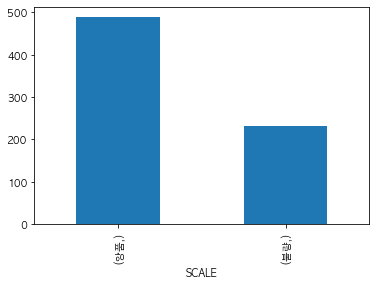

SCALE
양품       489
불량       231
dtype: int64


In [15]:
df_cnt= df[['SCALE']].value_counts()
df_cnt.plot.bar()
plt.show()
plt.close()
print(df[['SCALE']].value_counts())

# 분포 확인: 설명변수(연속형) 히스토그램=>이상치 처리 필요성 확인


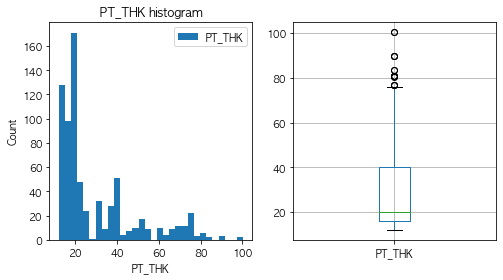

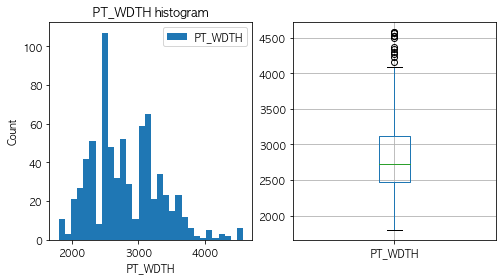

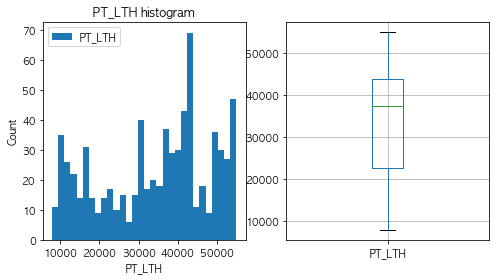

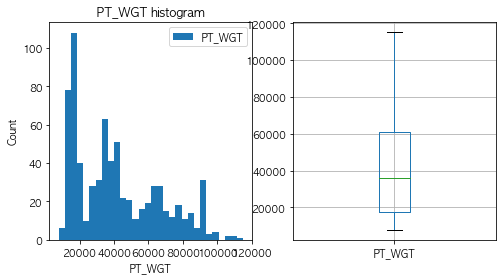

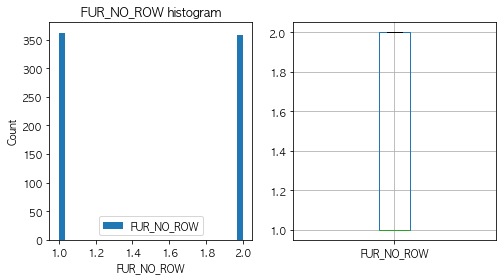

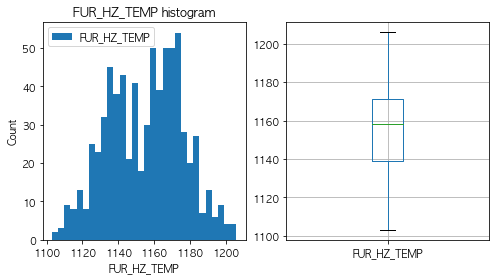

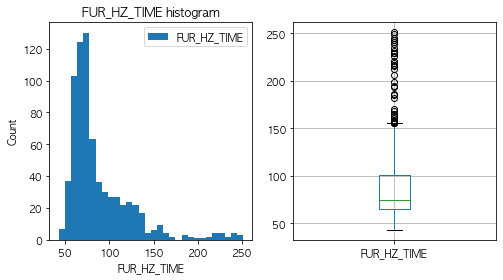

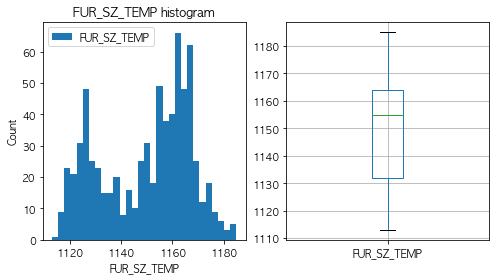

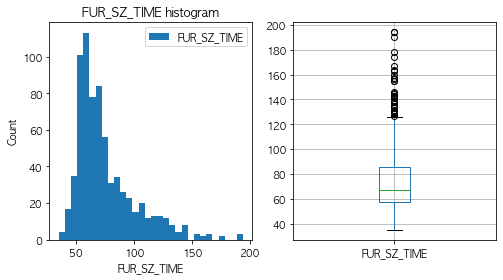

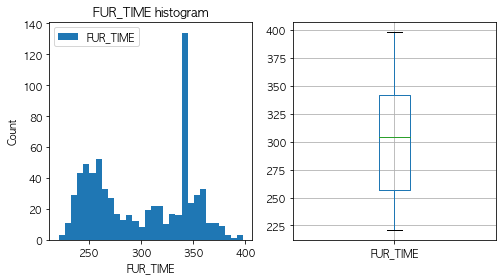

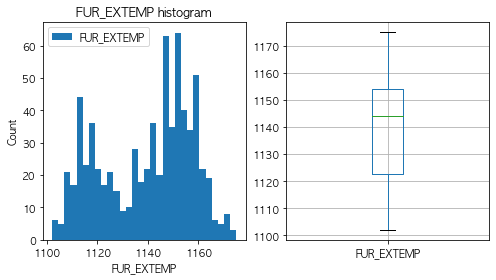

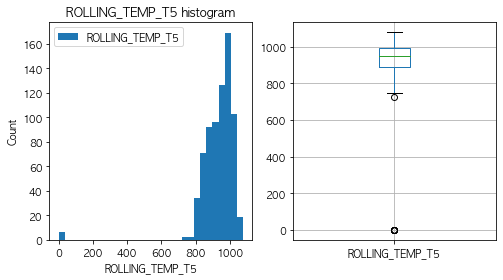

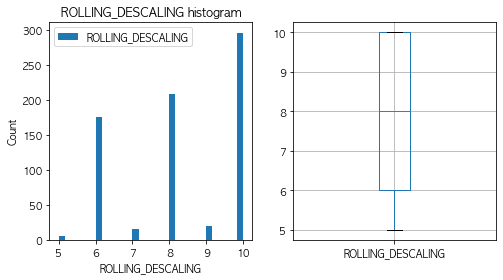

In [16]:
df_x = df.drop(['SCALE'],axis=1).select_dtypes(exclude='object')


for label in df_x.columns:
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.hist(df_x[label], label=label, bins=30)
    plt.legend()
    plt.title(label+' histogram')
    plt.ylabel('Count')
    plt.xlabel(label)
    
    plt.subplot(1,2,2)
    df_x[[label]].boxplot()

    plt.show()
    plt.close()

# 분포 확인: 설명변수(범주형) barplot
강종은 C0가 우세하다.

대부분 후판에 HSB 적용이 되었다.

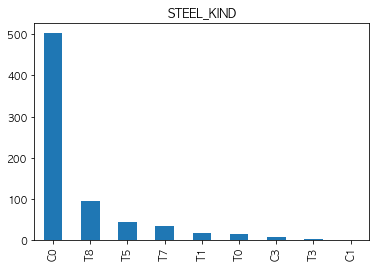

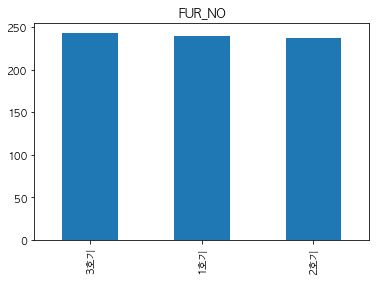

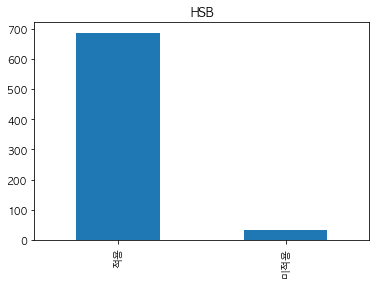

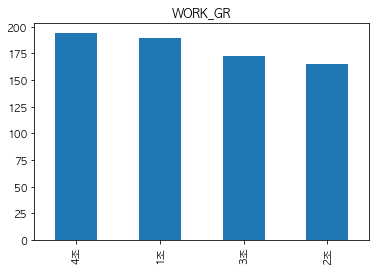

In [17]:
df_x = df.drop(['SCALE'],axis=1).select_dtypes(include='object')

for c in df_x.columns:
    df_cnt= df[c].value_counts()
    df_cnt.plot.bar()
    plt.title(c)
    plt.show()
    plt.close()

# 이상치 처리

IQR 기준으로 제거

In [18]:
df_num=df.select_dtypes(exclude='object')
df_char=df.select_dtypes(include='object')

In [19]:
collist=df_num.columns
for i in collist:
    print(i)
    quartile_1 = df_num[i].quantile(0.25)
    quartile_3 = df_num[i].quantile(0.75)
    IQR = quartile_3 - quartile_1
    
    lowest, highest = quartile_1 - 1.5 * IQR, quartile_3 + 1.5 * IQR
    df_num = df_num[(df_num[i]>=lowest)&(df_num[i]<=highest)]
    print(len(df_num.index))

PT_THK
704
PT_WDTH
692
PT_LTH
692
PT_WGT
692
FUR_NO_ROW
692
FUR_HZ_TEMP
692
FUR_HZ_TIME
660
FUR_SZ_TEMP
660
FUR_SZ_TIME
630
FUR_TIME
630
FUR_EXTEMP
630
ROLLING_TEMP_T5
626
ROLLING_DESCALING
626


# 이상치 제거 결과
1.5*IQR 이상 또는 이하 구간에 해당하는 이상치가 제거 되었다.

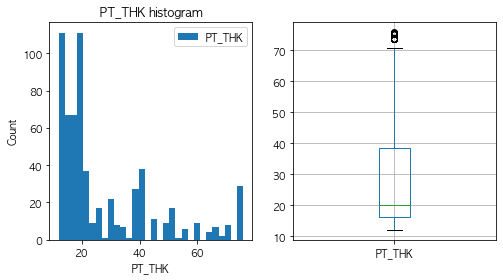

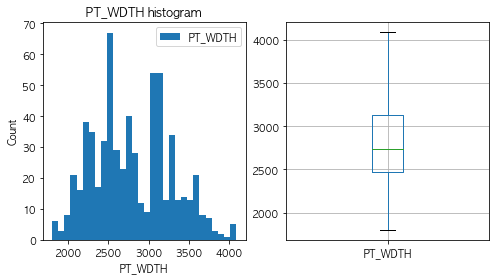

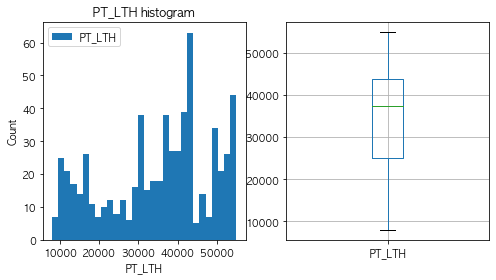

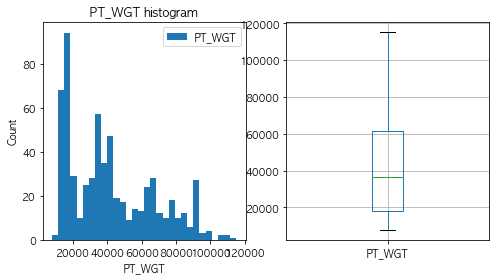

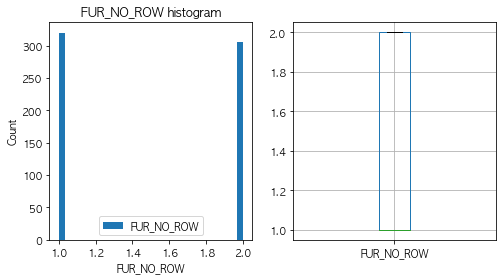

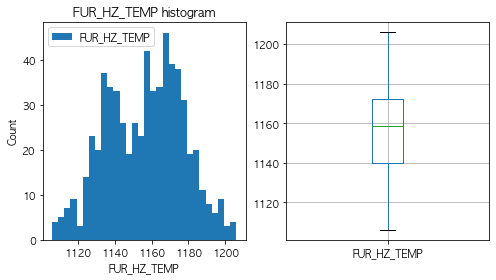

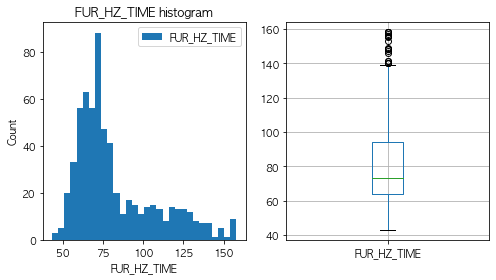

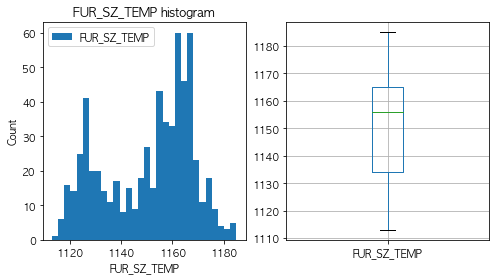

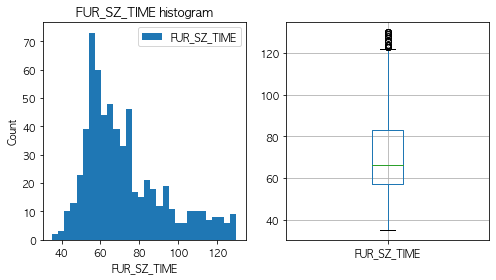

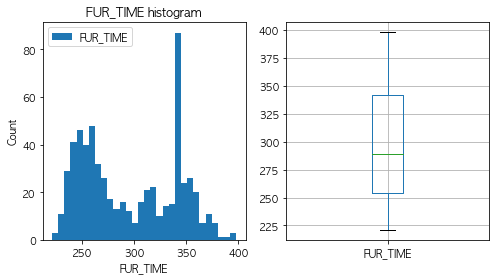

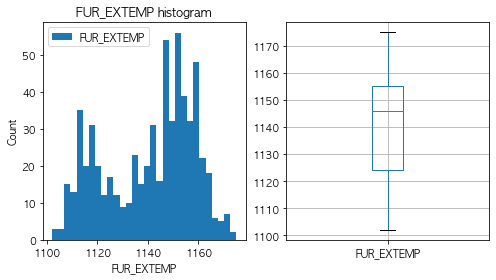

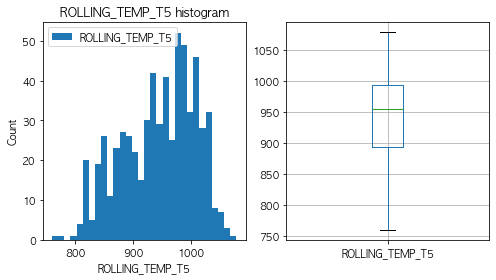

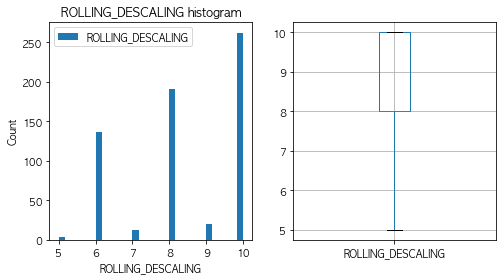

In [20]:
for label in df_num.columns:
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.hist(df_num[label], label=label, bins=30)
    plt.legend()
    plt.title(label+' histogram')
    plt.ylabel('Count')
    plt.xlabel(label)
    
    plt.subplot(1,2,2)
    df_num[[label]].boxplot()

    plt.show()
    plt.close()

# 2-5. 변수 파생 및 변환

## 파생 변수 생성: 강종을 C 또는 T로 재분류

In [21]:
df['STEEL_KIND'] = df['STEEL_KIND'].apply(lambda x: 'C' if x[0]=='C' else x)
df['STEEL_KIND'] = df['STEEL_KIND'].apply(lambda x: 'T' if x[0]=='T' else x)
df_num=df.select_dtypes(exclude='object')
df_char=df.select_dtypes(include='object')

## Scale 변환

In [22]:
scaler = StandardScaler()
np_num_scaled = scaler.fit_transform(df_num)
df_num_scaled= pd.DataFrame(np_num_scaled, columns=df_num.columns)

df_scaled = pd.concat([df_num_scaled, df_char], axis=1)
df_scaled.head()

,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING,SCALE,STEEL_KIND,FUR_NO,HSB,WORK_GR
0,0.155812,1.738951,-1.390441,-1.103810,-0.994460,-0.543782,0.767342,-0.949149,-0.626453,-0.409268,-0.816535,0.000734,-0.19693,양품,T,1호기,적용,2조
1,0.155812,1.738951,-1.390441,-1.103810,1.005571,-0.543782,0.932981,-0.835252,-0.856618,-0.387221,-1.096730,0.028567,-0.19693,양품,T,1호기,적용,2조
2,0.209106,1.568896,-1.095771,-0.944112,-0.994460,-1.263141,0.767342,-1.632537,-0.779897,-0.409268,-1.881276,-0.416748,-0.19693,양품,T,2호기,적용,3조
3,0.209106,1.568896,-1.095771,-0.944112,1.005571,-0.160124,1.015800,-1.290843,-0.281206,0.340311,-1.489003,-0.453858,-0.19693,양품,T,2호기,적용,3조
4,0.473482,0.562094,-1.518889,-1.174562,-0.994460,-0.735611,1.264257,-1.233894,-1.048422,0.296219,-1.208808,-0.565186,-0.19693,양품,T,3호기,적용,1조


# 3. EDA: 상관분석
## 설명변수(연속형)들 사이의 상관분석

### 가열로 추출온도 가열로 균열대온도의 상관계수 0.99로 매우 높은 현상
### 이유: "가열로 추출온도 =  가열로 균열대에서 slab가 추출될 때 온도"이므로 당연한 결과.
### 결정: 가열로 추출온도를 제거

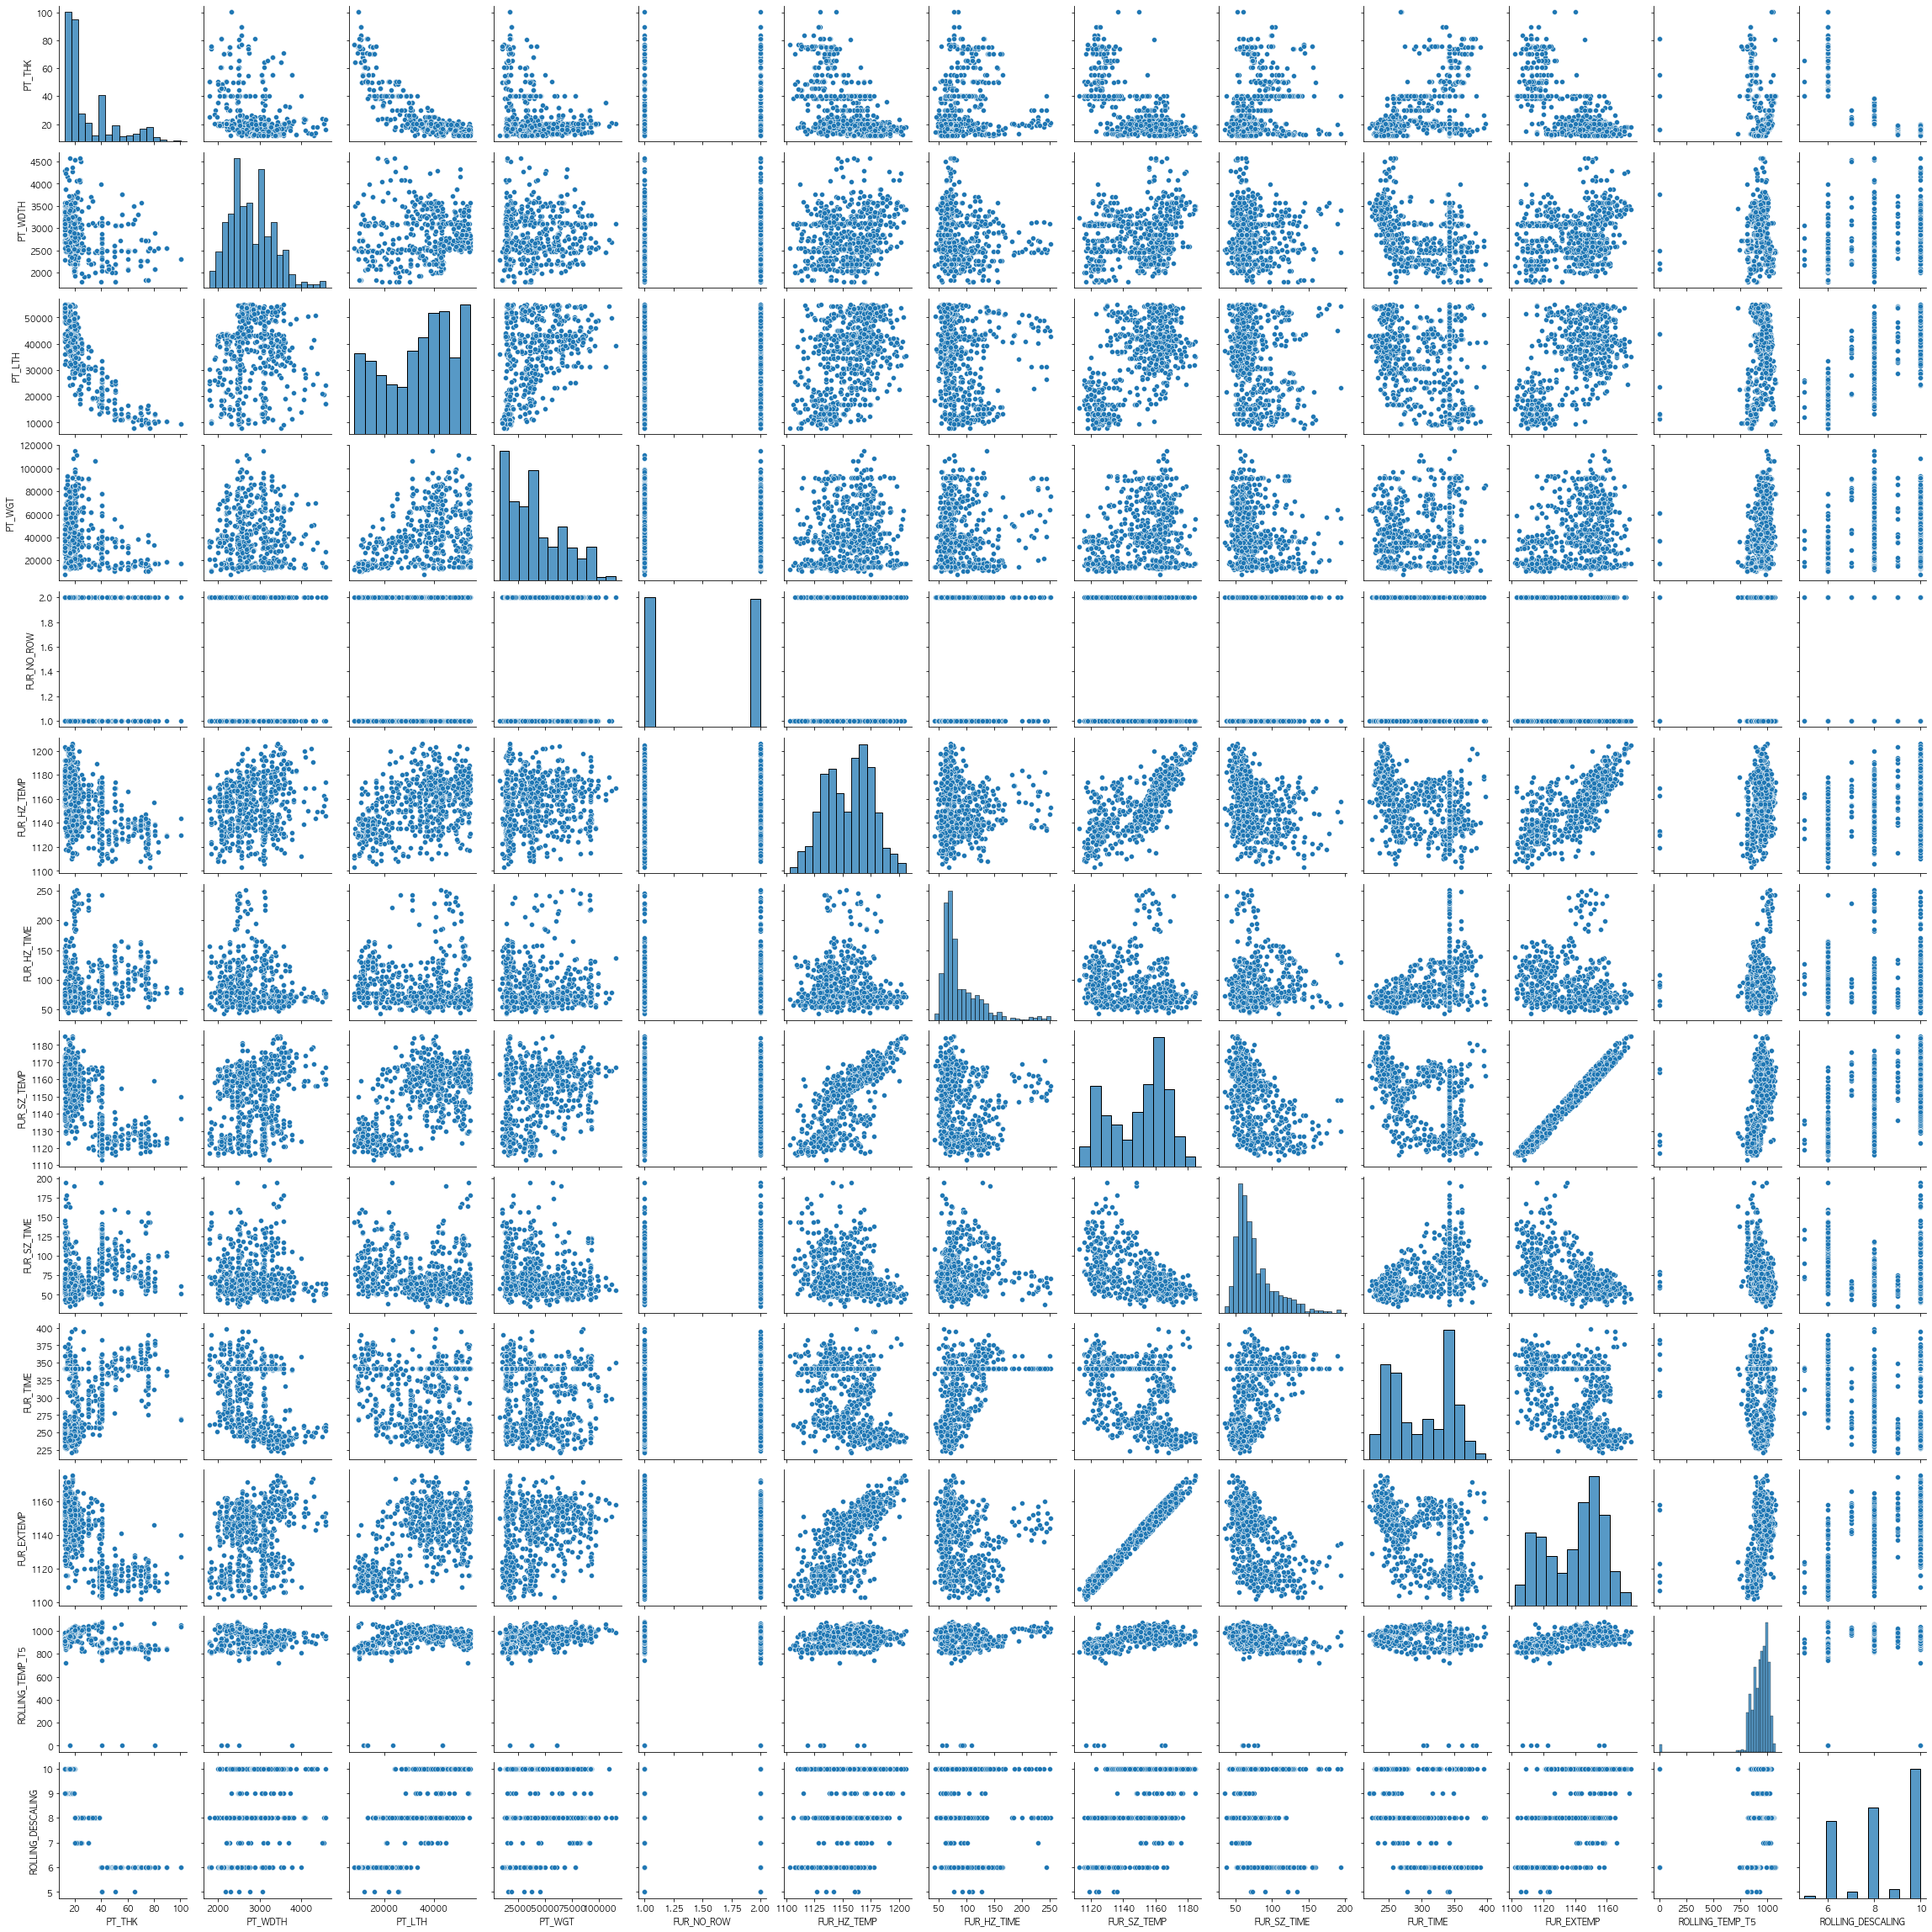

In [23]:
sns.pairplot(df_num)

In [24]:
df_num.corr().round(2)

,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING
PT_THK,1.00,-0.31,-0.86,-0.40,-0.00,-0.52,0.17,-0.69,0.27,0.41,-0.69,-0.37,-0.84
PT_WDTH,-0.31,1.00,0.12,0.03,0.01,0.18,-0.13,0.23,-0.05,-0.39,0.22,-0.02,0.34
PT_LTH,-0.86,0.12,1.00,0.45,-0.02,0.47,-0.09,0.65,-0.23,-0.25,0.64,0.31,0.81
PT_WGT,-0.40,0.03,0.45,1.00,-0.02,0.15,0.01,0.36,-0.19,-0.06,0.36,0.26,0.24
FUR_NO_ROW,-0.00,0.01,-0.02,-0.02,1.00,0.00,-0.01,0.01,0.06,0.02,0.01,-0.00,0.02
FUR_HZ_TEMP,-0.52,0.18,0.47,0.15,0.00,1.00,-0.11,0.77,-0.33,-0.35,0.76,0.27,0.47
FUR_HZ_TIME,0.17,-0.13,-0.09,0.01,-0.01,-0.11,1.00,-0.21,0.07,0.48,-0.20,0.01,-0.15
FUR_SZ_TEMP,-0.69,0.23,0.65,0.36,0.01,0.77,-0.21,1.00,-0.57,-0.48,0.99,0.45,0.65
FUR_SZ_TIME,0.27,-0.05,-0.23,-0.19,0.06,-0.33,0.07,-0.57,1.00,0.49,-0.57,-0.27,-0.29
FUR_TIME,0.41,-0.39,-0.25,-0.06,0.02,-0.35,0.48,-0.48,0.49,1.00,-0.47,-0.20,-0.37


# 3. EDA: 검정

## 목표변수(범주형)와 설명변수(범주형)의 상호 관련성 검정: 카이제곱 독립성 검정

In [25]:
from scipy import stats
from scipy.stats import chi2_contingency

print('chi-square test')
for i in df_char.drop(['SCALE'], axis=1).columns:
    chi, pval, dof, expected = stats.chi2_contingency(pd.crosstab(df_char['SCALE'],df_char[i]))
    if pval<0.05:
        print('{} p-value: {:0.10f}'.format(i, pval))


chi-square test
STEEL_KIND p-value: 0.0000000000
HSB p-value: 0.0000000000


# 3. EDA: 잠재인자 도출 (연속형 설명변수)

In [26]:
df_raw=df_scaled
df_raw.head(n=3)

,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING,SCALE,STEEL_KIND,FUR_NO,HSB,WORK_GR
0,0.155812,1.738951,-1.390441,-1.103810,-0.994460,-0.543782,0.767342,-0.949149,-0.626453,-0.409268,-0.816535,0.000734,-0.19693,양품,T,1호기,적용,2조
1,0.155812,1.738951,-1.390441,-1.103810,1.005571,-0.543782,0.932981,-0.835252,-0.856618,-0.387221,-1.096730,0.028567,-0.19693,양품,T,1호기,적용,2조
2,0.209106,1.568896,-1.095771,-0.944112,-0.994460,-1.263141,0.767342,-1.632537,-0.779897,-0.409268,-1.881276,-0.416748,-0.19693,양품,T,2호기,적용,3조


In [27]:
df_raw.replace({'SCALE': '불량'}, 1, inplace=True)
df_raw.replace({'SCALE': '양품'}, 0, inplace=True)


In [28]:
df_raw_x = df_raw.drop('SCALE', axis=1)
df_raw_y = df_raw['SCALE']

In [29]:
def fun_plot_hist(data, var):#, meaning=[]):
    min_, max_ = min(data[var]), max(data[var])
    plt.hist(data[data["SCALE"] == "양품"][var], label = "양품", alpha = 0.3, range=(min_, max_), color ='blue')
    plt.hist(data[data["SCALE"] == "불량"][var], label = "불량", alpha = 0.5, range=(min_, max_), color ='red')
    plt.legend()
    plt.xlabel(var)
    plt.legend(loc=1)
    plt.show()
    plt.close()

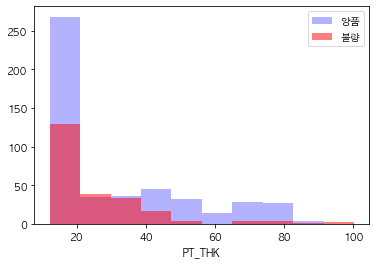

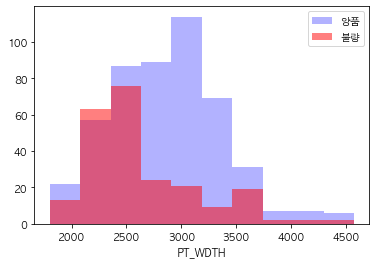

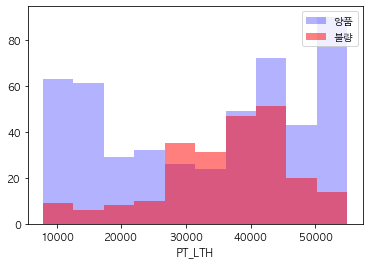

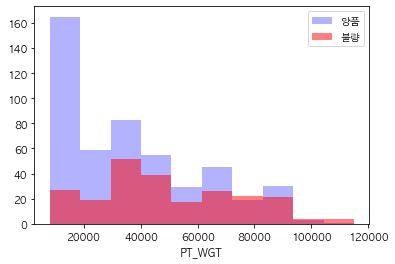

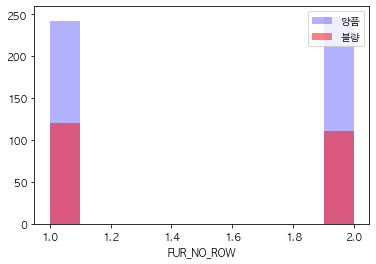

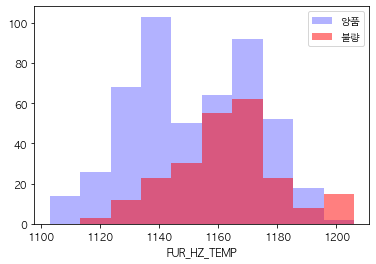

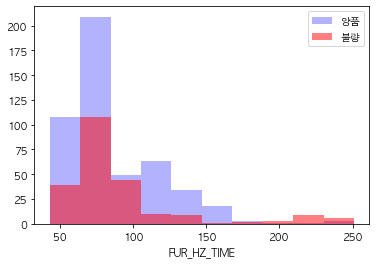

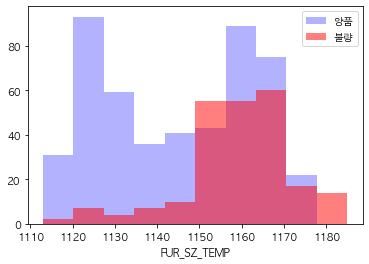

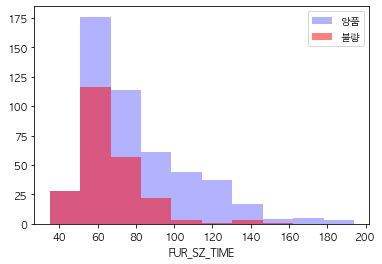

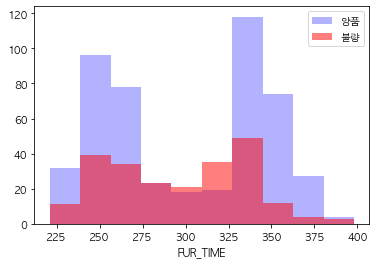

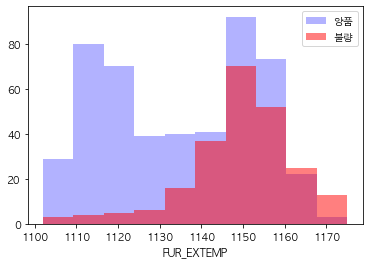

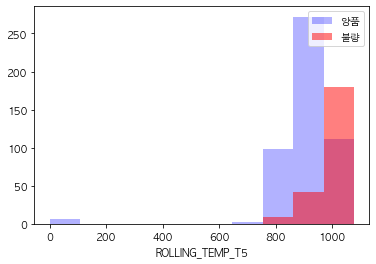

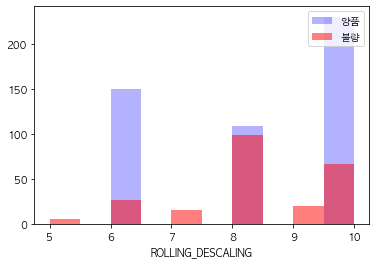

In [30]:
labels=df_num.columns
for label in labels:
    fun_plot_hist(df, label)

# 4-1. 영향인자 선정: 로지스틱 회귀

## 선형회귀 모델 적합

In [31]:
#목표변수~설명변수
var=' + '.join(df_raw_x.columns)
var='SCALE ~ '+var
print(var)

SCALE ~ PT_THK + PT_WDTH + PT_LTH + PT_WGT + FUR_NO_ROW + FUR_HZ_TEMP + FUR_HZ_TIME + FUR_SZ_TEMP + FUR_SZ_TIME + FUR_TIME + FUR_EXTEMP + ROLLING_TEMP_T5 + ROLLING_DESCALING + STEEL_KIND + FUR_NO + HSB + WORK_GR


In [32]:
from sklearn.model_selection import train_test_split
from statsmodels.api import Logit

df_raw_train, df_raw_test = train_test_split(df_raw,
                                                  test_size = 0.3,
                                                  random_state = 1234)

inputline ='SCALE ~ PT_THK + PT_WDTH + PT_LTH + PT_WGT + FUR_NO_ROW + FUR_HZ_TEMP + FUR_HZ_TIME + FUR_SZ_TEMP + FUR_SZ_TIME + FUR_TIME + FUR_EXTEMP + ROLLING_TEMP_T5 + ROLLING_DESCALING + C(STEEL_KIND) + C(FUR_NO) + C(HSB) + C(WORK_GR)'
scaled_log_model = Logit.from_formula(inputline, df_raw_train)

scaled_log_result = scaled_log_model.fit()
print(scaled_log_result.summary())

         Current function value: 0.257339
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  504
Model:                          Logit   Df Residuals:                      483
Method:                           MLE   Df Model:                           20
Date:                Wed, 22 Sep 2021   Pseudo R-squ.:                  0.5882
Time:                        20:20:50   Log-Likelihood:                -129.70
converged:                      False   LL-Null:                       -314.97
Covariance Type:            nonrobust   LLR p-value:                 2.569e-66
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             32.5737   5.25e+05    6.2e-05      1.000   -1.03e+06    1.03e+06
C(STEEL_KIND)[T.T]     1.6291      1.335 

/Users/dasol/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# 4-2. 영향인자 선정: DT

In [51]:
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# dummy 변수 설정

In [52]:
df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy_x = df_raw_dummy.drop('SCALE', axis=1)
df_raw_dummy_y = df_raw_dummy['SCALE']

# train, test x,y set

In [53]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_dummy_x,df_raw_dummy_y, test_size = 0.3, random_state=1234)
print('train x data size : {}'.format(df_train_x.shape))
print('train y data size : {}'.format(df_train_y.shape))
print('test x data size : {}'.format(df_test_x.shape))
print('test y data size : {}'.format(df_test_y.shape))

train x data size : (504, 24)
train y data size : (504,)
test x data size : (216, 24)
test y data size : (216,)


Text(0, 0.5, '변수')

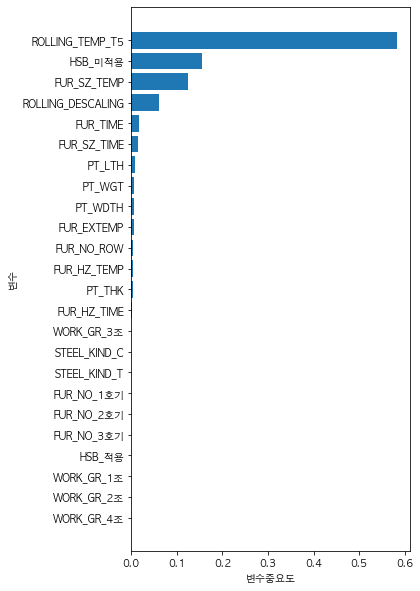

In [54]:

tree_uncustomized =DecisionTreeClassifier(random_state=1234)
tree_uncustomized.fit(df_raw_dummy_x, df_raw_dummy_y)

feature_name = df_raw_dummy.drop('SCALE', axis=1).columns

df_importance = pd.DataFrame()
df_importance['Feature'] = feature_name
df_importance['Importance'] = tree_uncustomized.feature_importances_
df_importance.sort_values('Importance', ascending=True, inplace=True)
# df_importance.round(3)

coordinates = range(len(df_importance))
plt.figure(figsize=(5,10))
plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수중요도')
plt.ylabel('변수')

# 4-3. 영향인자 선정: RF

In [55]:
from sklearn.ensemble import RandomForestClassifier

rf_uncustomized = RandomForestClassifier(random_state=1234)
rf_uncustomized.fit(df_raw_dummy_x, df_raw_dummy_y)
# print('Tree_uncustomized Score on training set: {:3f}'.format(rf_uncustomized.score(df_train_x, df_train_y)))
# print('Tree_uncustomized Score on test set: {:3f}'.format(rf_uncustomized.score(df_test_x, df_test_y)))

RandomForestClassifier(random_state=1234)

Text(0, 0.5, '변수')

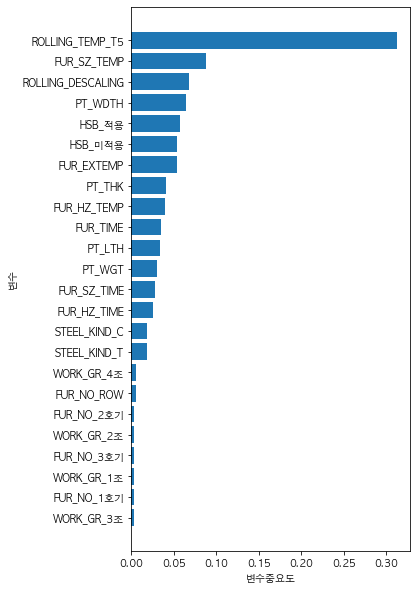

In [56]:
feature_name = df_raw_dummy_x.columns

df_importance = pd.DataFrame()
df_importance['Feature'] = feature_name
df_importance['Importance'] = rf_uncustomized.feature_importances_
df_importance.sort_values('Importance', ascending=True, inplace=True)
# df_importance.round(3)

coordinates = range(len(df_importance))
plt.figure(figsize=(5,10))
plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수중요도')
plt.ylabel('변수')

# 4-4. 영향인자 선정: GB

In [57]:
from sklearn.ensemble import GradientBoostingClassifier as gbc


gb_uncustomized =gbc(random_state=1234)
gb_uncustomized.fit(df_raw_dummy_x, df_raw_dummy_y)
print("Accuracy in train set:{:.3f}".format(gb_uncustomized.score(df_raw_dummy_x, df_raw_dummy_y)))
# print("Accuracy in test set:{:.3f}".format(gb_uncustomized.score(df_test_x,df_test_y)))


Accuracy in train set:1.000


Text(0, 0.5, '설명변수')

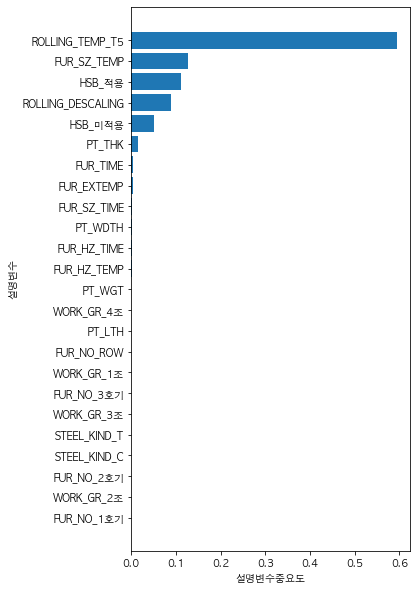

In [58]:
v_feature_name = df_raw_dummy_x.columns
df_importance=pd.DataFrame()
df_importance["Feature"]=v_feature_name
df_importance["Importance"]=gb_uncustomized.feature_importances_

df_importance.sort_values("Importance",ascending=False,inplace=True)
# display(df_importance.round(3))
df_importance.sort_values("Importance",ascending=True,inplace=True)
coordinates=range(len(df_importance))
plt.figure(figsize=(5,10))

plt.barh(y=coordinates,width=df_importance["Importance"])
plt.yticks(coordinates,df_importance["Feature"])
plt.xlabel("설명변수중요도")
plt.ylabel("설명변수")


# 5-1. 📌 개선안 도출: 선정한 주요 영향인자만을 사용한 DT 분석

In [59]:
df = pd.read_csv('SCALE불량.csv', engine='python', encoding='cp949')
df['STEEL_KIND'] = df['STEEL_KIND'].apply(lambda x: 'C' if x[0]=='C' else x)
df['STEEL_KIND'] = df['STEEL_KIND'].apply(lambda x: 'T' if x[0]=='T' else x)

df.replace({'SCALE': '불량'}, 1, inplace=True)
df.replace({'SCALE': '양품'}, 0, inplace=True)
df_dummy = pd.get_dummies(df)

df_final=df_dummy[['STEEL_KIND_C','FUR_SZ_TEMP', 'ROLLING_TEMP_T5', 'HSB_적용','SCALE']]

In [60]:
df_y = df_final['SCALE']
df_x = df_final.drop('SCALE', axis=1, inplace=False)

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y, test_size=0.3, random_state=1234)

print('train data X size: {}'.format(df_train_x.shape))
print('train data Y size: {}'.format(df_train_y.shape))
print('test data X size: {}'.format(df_test_x.shape))
print('test data Y size: {}'.format(df_test_y.shape))

train data X size: (504, 4)
train data Y size: (504,)
test data X size: (216, 4)
test data Y size: (216,)


## DecisionTreeClassifier Model 의 최적 파라메터 탐색: GridSearchCV
best parameter:
{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 4}

best score:
0.956

In [61]:
from sklearn.model_selection import GridSearchCV

para_split= [n_split*2 for n_split in range(2,20)] # 분리 노드의 최소 자료 수
para_leaf= [n_leaf for n_leaf in range(1,20)] # 잎사귀 최소 자료 수
para_depth= [i for i in range(1,11)] # 분리 노드의 최소 자료 수

estimator = DecisionTreeClassifier()
param_grid={"max_depth":para_depth,"min_samples_split":para_split,"min_samples_leaf":para_leaf}
grid_dt= GridSearchCV(estimator,param_grid,scoring="accuracy",n_jobs=-1)
grid_dt.fit(df_train_x,df_train_y)

print("best estimator model:\n{}".format(grid_dt.best_estimator_))
print("\nbest parameter:\n{}".format(grid_dt.best_params_))
print("\nbest score:\n{}".format(grid_dt.best_score_.round(3)))

best estimator model:
DecisionTreeClassifier(max_depth=3, min_samples_split=4)

best parameter:
{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 4}

best score:
0.956


## 최적 파라메터를 대입한 Model 결과


In [62]:
tree_final =DecisionTreeClassifier(max_depth=3,min_samples_leaf=1,min_samples_split=4, random_state=1234)
tree_final.fit(df_x,df_y) 

DecisionTreeClassifier(max_depth=3, min_samples_split=4, random_state=1234)

In [63]:
pd.crosstab(df_final['SCALE'],df_final['HSB_적용'], margins=True)

HSB_적용,0,1,All
SCALE,,,
0,0,489,489
1,33,198,231
All,33,687,720


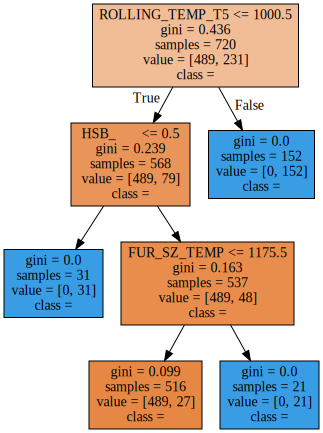

In [64]:
export_graphviz(tree_final,out_file="tree_final.dot",class_names=["양품","불량"],
                    feature_names = df_x.columns,impurity =True,filled=True)
with open("tree_final.dot") as f:
    dot_graph = f.read()
g = graphviz.Source(dot_graph)
g.format='png'
g.render(filename='Final_3')
display(g)

In [65]:
# df_x.columns
df_importance = pd.DataFrame()
df_importance['Feature'] = df_x.columns
df_importance['Importance'] = tree_final.feature_importances_
df_importance.sort_values('Importance', ascending=True, inplace=True)
df_importance.round(3)

,Feature,Importance
0,STEEL_KIND_C,0.000
1,FUR_SZ_TEMP,0.138
3,HSB_적용,0.185
2,ROLLING_TEMP_T5,0.677


Text(0, 0.5, '변수')

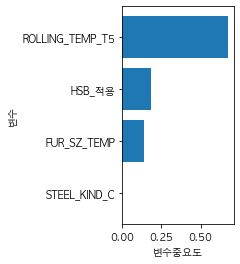

In [66]:
coordinates = range(len(df_importance))
plt.figure(figsize=(2,4))
plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수중요도')
plt.ylabel('변수')

# 5-2. 📌 개선안 도출: 선정한 주요 영향인자 중 하나의 변수만을 사용한 DT 분석
## 이유: vital few 설명 변수 하나를 decision tree에 학습시켜서 연속형 변수를 범주화 한다.
## 이를 통해 각  vital few 변수를 어떤 범주에서 관리해야 불량률을 낮출 수 있을지 개선안 도출 가능하다.

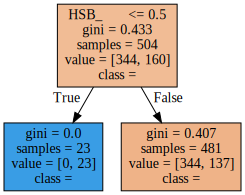

In [67]:
name='HSB_적용'

df_1=df_final[[name,'SCALE']]
df_1_x, df_1_y= df_1.drop('SCALE', axis=1, inplace=False), df_1['SCALE']

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_1_x, df_1_y, test_size=0.3, random_state=1234)


tree_final =DecisionTreeClassifier(max_depth=9,min_samples_leaf=7,min_samples_split=26, random_state=1234)
tree_final.fit(df_train_x,df_train_y) 

export_graphviz(tree_final,out_file="tree_final.dot",class_names=["양품","불량"],
                feature_names = [name],impurity =True,filled=True)
with open("tree_final.dot") as f:
    dot_graph = f.read()
g = graphviz.Source(dot_graph)
g.format='png'
g.render(filename=name)
display(g)

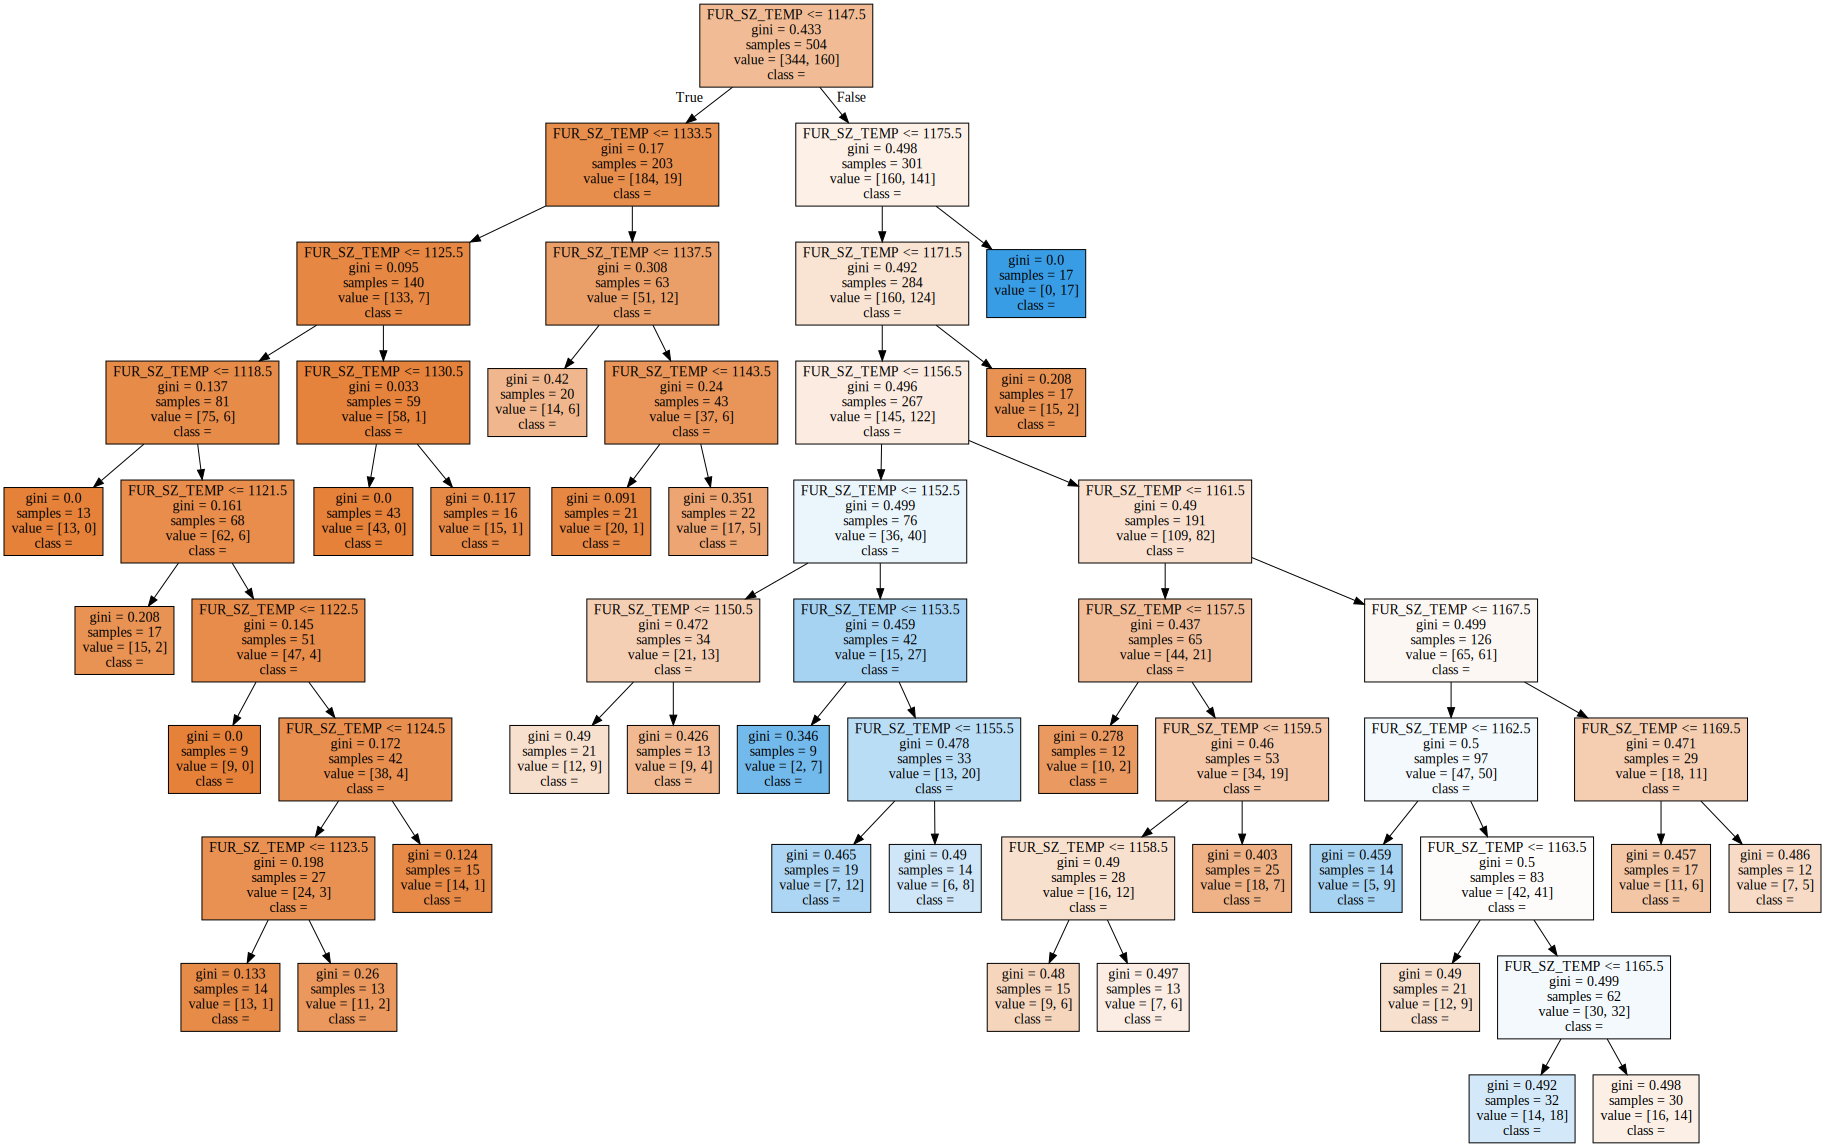

In [68]:
name='FUR_SZ_TEMP'

df_1=df_final[[name,'SCALE']]
df_1_x, df_1_y= df_1.drop('SCALE', axis=1, inplace=False), df_1['SCALE']

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_1_x, df_1_y, test_size=0.3, random_state=1234)


tree_final =DecisionTreeClassifier(max_depth=9,min_samples_leaf=7,min_samples_split=26, random_state=1234)
tree_final.fit(df_train_x,df_train_y) 

export_graphviz(tree_final,out_file="tree_final.dot",class_names=["양품","불량"],
                feature_names = [name],impurity =True,filled=True)
with open("tree_final.dot") as f:
    dot_graph = f.read()
g = graphviz.Source(dot_graph)
g.format='png'
g.render(filename=name)
display(g)

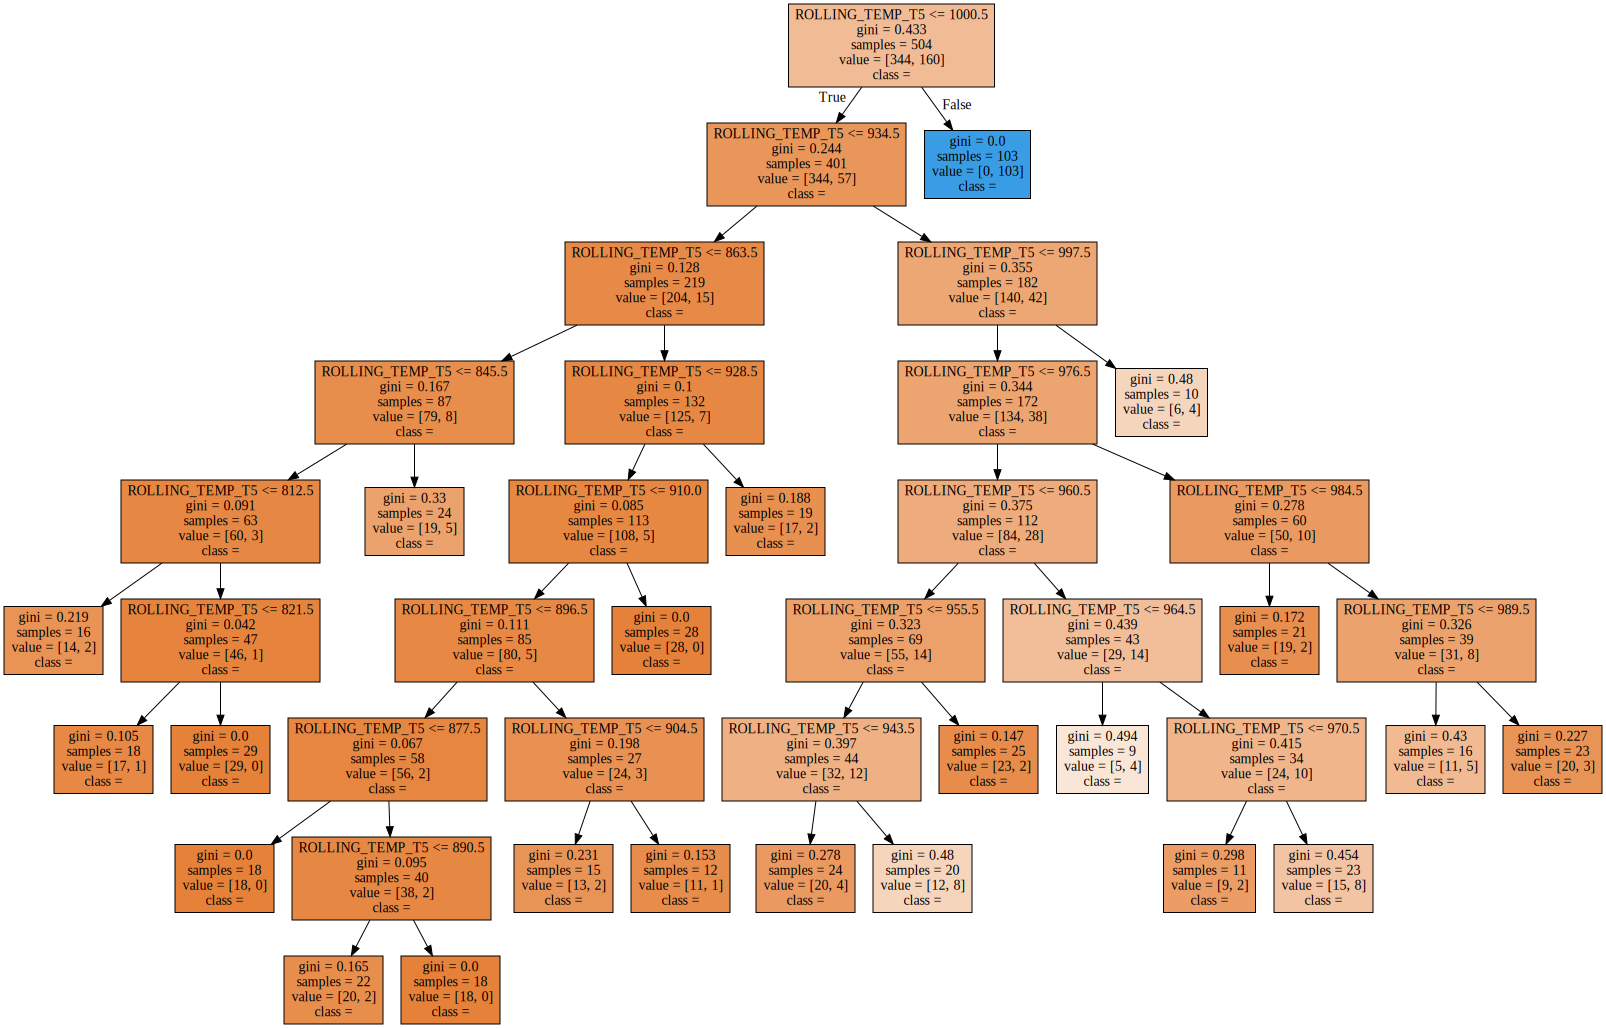

In [69]:
name='ROLLING_TEMP_T5'

df_1=df_final[[name,'SCALE']]
df_1_x, df_1_y= df_1.drop('SCALE', axis=1, inplace=False), df_1['SCALE']

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_1_x, df_1_y, test_size=0.3, random_state=1234)


tree_final =DecisionTreeClassifier(max_depth=9,min_samples_leaf=7,min_samples_split=26, random_state=1234)
tree_final.fit(df_train_x,df_train_y) 

export_graphviz(tree_final,out_file="tree_final.dot",class_names=["양품","불량"],
                feature_names = [name],impurity =True,filled=True)
with open("tree_final.dot") as f:
    dot_graph = f.read()
g = graphviz.Source(dot_graph)
g.format='png'
g.render(filename=name)
display(g)

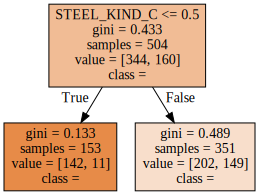

In [71]:
name='STEEL_KIND_C'

df_1=df_final[[name,'SCALE']]
df_1_x, df_1_y= df_1.drop('SCALE', axis=1, inplace=False), df_1['SCALE']

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_1_x, df_1_y, test_size=0.3, random_state=1234)


tree_final =DecisionTreeClassifier(max_depth=9,min_samples_leaf=7,min_samples_split=26, random_state=1234)
tree_final.fit(df_train_x,df_train_y) 

export_graphviz(tree_final,out_file="tree_final.dot",class_names=["양품","불량"],
                feature_names = [name],impurity =True,filled=True)
with open("tree_final.dot") as f:
    dot_graph = f.read()
g = graphviz.Source(dot_graph)
g.format='png'
g.render(filename=name)
display(g)

# 5-3. 개선안 도출 with scaled-data

train data X size: (504, 3)
train data Y size: (504,)
test data X size: (216, 3)
test data Y size: (216,)


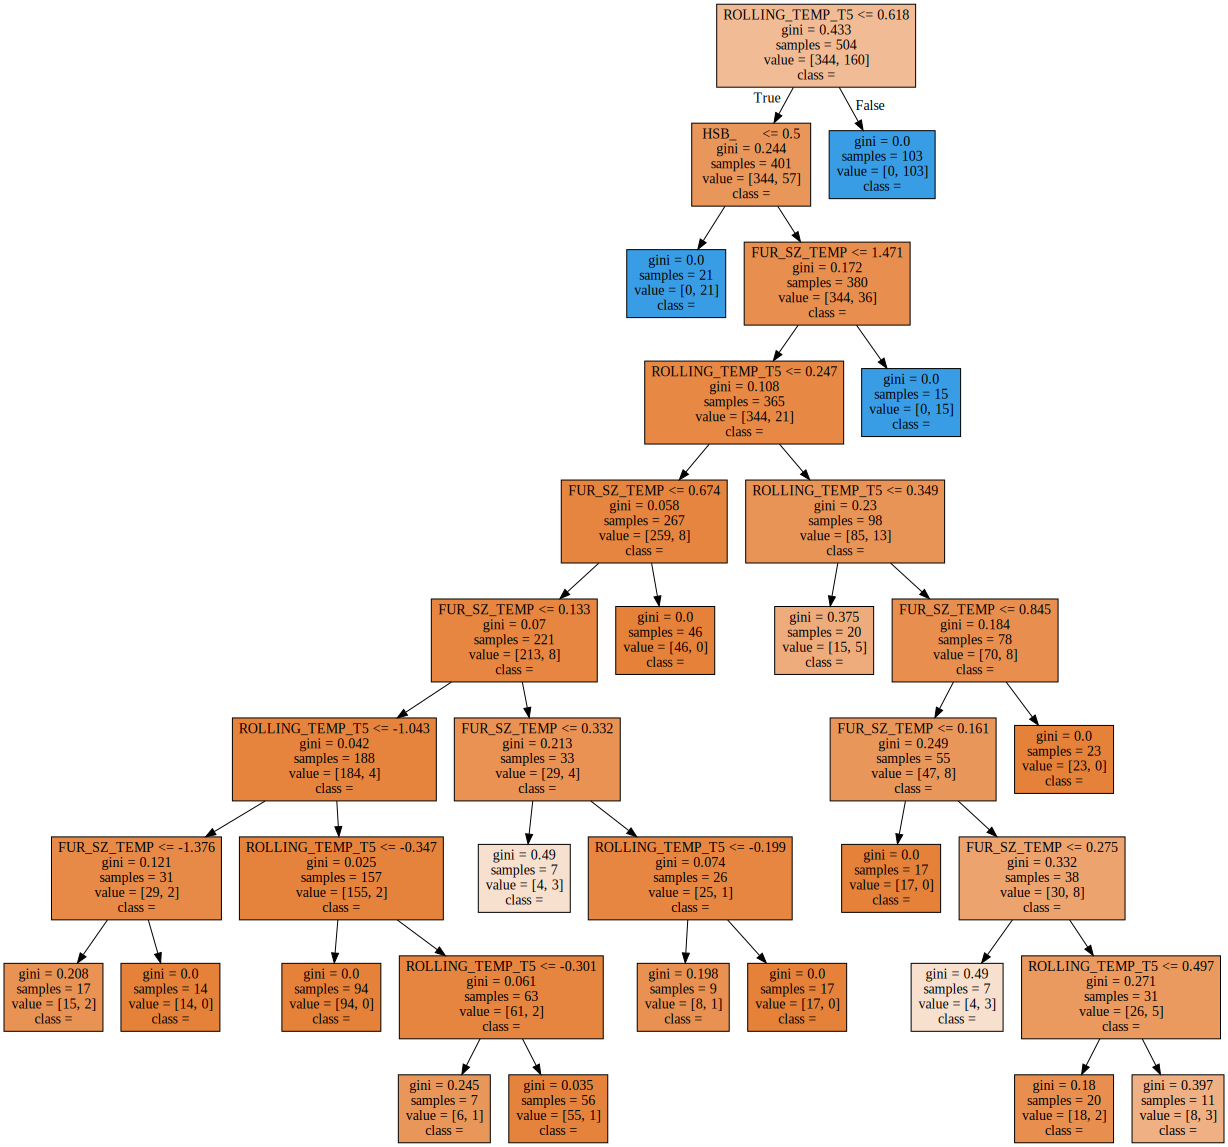

In [66]:
df_final=df_raw_dummy[['FUR_SZ_TEMP', 'ROLLING_TEMP_T5', 'HSB_적용','SCALE']]
df_final_y = df_final['SCALE']
df_final_x = df_final.drop('SCALE', axis=1, inplace=False)

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_final_x, df_final_y, test_size=0.3, random_state=1234)

print('train data X size: {}'.format(df_train_x.shape))
print('train data Y size: {}'.format(df_train_y.shape))
print('test data X size: {}'.format(df_test_x.shape))
print('test data Y size: {}'.format(df_test_y.shape))

tree_final =DecisionTreeClassifier(max_depth=9,min_samples_leaf=7,min_samples_split=26, random_state=1234)
tree_final.fit(df_train_x,df_train_y) 

export_graphviz(tree_final,out_file="tree_final.dot",class_names=["양품","불량"],
                feature_names = df_final_x.columns,impurity =True,filled=True)
with open("tree_final.dot") as f:
    dot_graph = f.read()
g = graphviz.Source(dot_graph)
g.format='png'
g.render(filename='final')
display(g)